<h1> Time series prediction, end-to-end </h1>

This notebook illustrates several models to find the next value of a time-series:
<ol>
<li> Linear
<li> DNN
<li> CNN 
<li> RNN
</ol>

<h3> Simulate some time-series data </h3>

Essentially a set of sinusoids with random amplitudes and frequencies.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


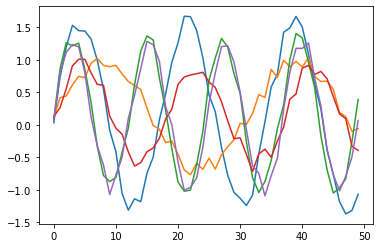

In [2]:
import numpy as np
import matplotlib.pyplot as plt

SEQ_LEN = 50

def create_time_series():
    freq = (np.random.random()*0.5) + 0.1  # 0.1 to 0.6
    ampl = np.random.random() + 0.5  # 0.5 to 1.5
    noise = [np.random.random()*0.3 for i in range(SEQ_LEN)] # -0.3 to +0.3 uniformly distributed
    x = np.sin(np.arange(0,SEQ_LEN) * freq) * ampl + noise
    return x

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i in range(0, 5):
    plt.plot(create_time_series());  # 5 series

In [3]:
def to_csv(filename, N):
    with open(filename, 'w') as ofp:
        for lineno in range(0, N):
            seq = create_time_series()
            line = ",".join(map(str, seq))
            ofp.write(line + '\n')

import os
try:
    os.makedirs("data/sines/")
except OSError:
    pass

np.random.seed(1) # makes data generation reproducible

to_csv("data/sines/train-1.csv", 1000)  # 1000 sequences
to_csv("data/sines/valid-1.csv", 250)

<h3> Read the data in a Pandas dataframe </h3>

Make sure the code works as intended.

In [4]:
TIMESERIES_COL = 'height'
N_OUTPUTS = 1  # in each sequence, 1-49 are features, and 50 is label
SEQ_LEN = None
DEFAULTS = None
N_INPUTS = 49

import pandas as pd

train = pd.read_csv("data/sines/train-1.csv", header=None)
valid = pd.read_csv("data/sines/valid-1.csv", header=None)

X = train.iloc[:,:48]
y = train.iloc[:, 49]


Xv = valid.iloc[:,:48]
yv = valid.iloc[:, 49]

<h3> Model </h3>

Linear, DNN, CNN, RNN.

2022-01-06 12:08:18.722769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-06 12:08:18.854904: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-06 12:08:18.855899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-06 12:08:18.858082: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Epoch 1/150
32/32 [==============================] - 2s 6ms/step - loss: 0.5980 - mse: 0.5980
Epoch 2/150
32/32 [==============================] - 0s 6ms/step - loss: 0.4009 - mse: 0.4009
Epoch 3/150
32/32 [==============================] - 0s 4ms/step - loss: 0.2955 - mse: 0.2955
Epoch 4/150
32/32 [==============================] - 0s 4ms/step - loss: 0.1973 - mse: 0.1973
Epoch 5/150
32/32 [==============================] - 0s 5ms/step - loss: 0.1104 - mse: 0.1104
Epoch 6/150
32/32 [==============================] - 0s 4ms/step - loss: 0.0664 - mse: 0.0664
Epoch 7/150
32/32 [==============================] - 0s 4ms/step - loss: 0.0448 - mse: 0.0448
Epoch 8/150
32/32 [==============================] - 0s 4ms/step - loss: 0.0348 - mse: 0.0348
Epoch 9/150
32/32 [==============================] - 0s 5ms/step - loss: 0.0296 - mse: 0.0296
Epoch 10/150
32/32 [==============================] - 0s 4ms/step - loss: 0.0277 - mse: 0.0277
Epoch 11/150
32/32 [==============================] - 0s 5m

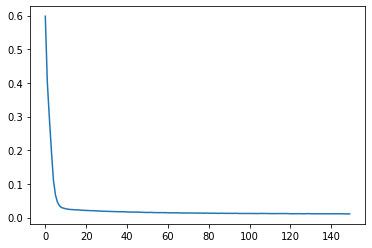

In [5]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape = [48], name = TIMESERIES_COL))

# comment the line below for linear model
model.add(tf.keras.layers.Dense(5, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', loss = "mse", metrics = ["mse"])
history = model.fit(X, y, epochs=150)

plt.plot(history.history['loss'])

In [6]:
model.evaluate(Xv, yv)

8/8 [==============================] - 0s 3ms/step - loss: 0.0140 - mse: 0.0140


[0.013991239480674267, 0.013991239480674267]

In [7]:
X_np = X.to_numpy()
X_np.shape

(1000, 48)

In [8]:
model_cnn = tf.keras.models.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape = [N_INPUTS - 1], name = TIMESERIES_COL),
        tf.keras.layers.Reshape(target_shape = [N_INPUTS - 1, 1]),
        tf.keras.layers.Conv1D(filters = (N_INPUTS - 1) // 2, kernel_size = 3, padding = "same", activation = tf.nn.relu),
        tf.keras.layers.MaxPooling1D(pool_size = 2, strides = 2),
        tf.keras.layers.Conv1D(filters = (N_INPUTS -1) // 2, kernel_size = 3, padding = "same", activation = tf.nn.relu),
        tf.keras.layers.MaxPooling1D(pool_size = 2, strides = 2),

        tf.keras.layers.Flatten(), #### THIS MAKES ALL THE DIFFERENCE
        
        tf.keras.layers.Dense(units = 3, activation = tf.nn.relu),
        tf.keras.layers.Dense(units = 1, activation = None)
    ])

model_cnn.compile(optimizer='adam', loss = "mse", metrics = ["mse"])

history = model_cnn.fit(X_np, y, epochs=150)

Epoch 1/150


2022-01-06 12:08:51.637252: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301
2022-01-06 12:08:53.256931: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


32/32 [==============================] - 4s 10ms/step - loss: 0.4797 - mse: 0.4797
Epoch 2/150
32/32 [==============================] - 0s 7ms/step - loss: 0.3093 - mse: 0.3093
Epoch 3/150
32/32 [==============================] - 0s 7ms/step - loss: 0.1281 - mse: 0.1281
Epoch 4/150
32/32 [==============================] - 0s 8ms/step - loss: 0.0489 - mse: 0.0489
Epoch 5/150
32/32 [==============================] - 0s 7ms/step - loss: 0.0287 - mse: 0.0287
Epoch 6/150
32/32 [==============================] - 0s 7ms/step - loss: 0.0194 - mse: 0.0194
Epoch 7/150
32/32 [==============================] - 0s 7ms/step - loss: 0.0184 - mse: 0.0184
Epoch 8/150
32/32 [==============================] - 0s 7ms/step - loss: 0.0169 - mse: 0.0169
Epoch 9/150
32/32 [==============================] - 0s 7ms/step - loss: 0.0158 - mse: 0.0158
Epoch 10/150
32/32 [==============================] - 0s 8ms/step - loss: 0.0149 - mse: 0.0149
Epoch 11/150
32/32 [==============================] - 0s 9ms/step - lo

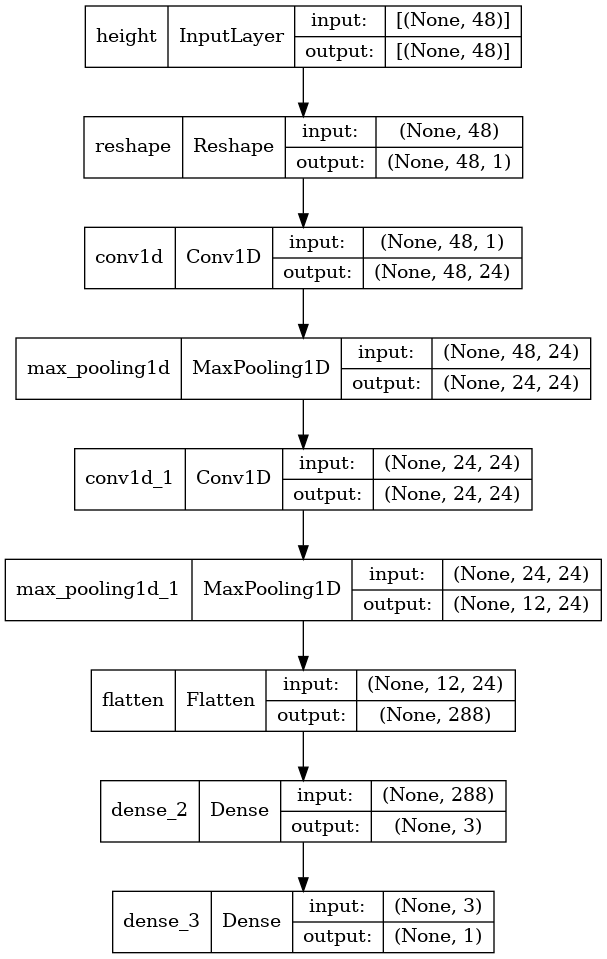

In [9]:
tf.keras.utils.plot_model(model_cnn, show_shapes=True)

In [10]:
model_cnn.evaluate(Xv, yv)

8/8 [==============================] - 0s 10ms/step - loss: 0.0128 - mse: 0.0128


[0.012795408256351948, 0.012795408256351948]

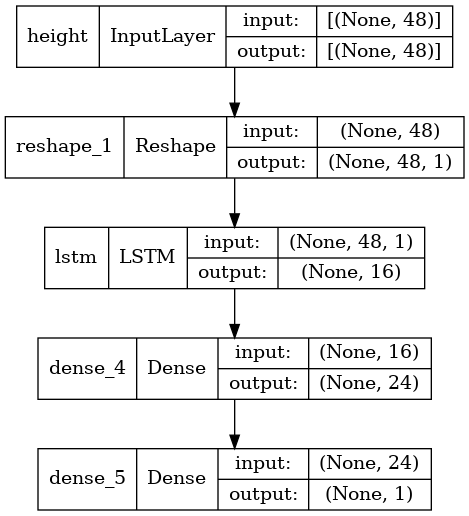

In [11]:
N_INPUTS = 48
CELL_SIZE = 16  # size of the internal state in each of the cells

model_rnn = tf.keras.models.Sequential([
    
    tf.keras.layers.InputLayer(input_shape = [N_INPUTS], name = TIMESERIES_COL),

    # the reshape at the end, the 1, the 3rd dimension, represents how many features we have for each input
    tf.keras.layers.Reshape(target_shape = [N_INPUTS, 1]),

    tf.keras.layers.LSTM(units = CELL_SIZE),
    
    # one hidden layer
    tf.keras.layers.Dense(units = N_INPUTS // 2, activation = tf.nn.relu),
    tf.keras.layers.Dense(units = 1, activation = None)
])

model_rnn.compile(optimizer='adam', loss = "mse", metrics = ["mse"])

tf.keras.utils.plot_model(model_rnn, show_shapes=True)


In [12]:
history = model_rnn.fit(X_np, y, epochs=100, validation_data=(Xv, yv))
model_rnn.evaluate(Xv, yv)

Epoch 1/100
32/32 [==============================] - 3s 38ms/step - loss: 0.5872 - mse: 0.5872 - val_loss: 0.4931 - val_mse: 0.4931
Epoch 2/100
32/32 [==============================] - 0s 15ms/step - loss: 0.4847 - mse: 0.4847 - val_loss: 0.3873 - val_mse: 0.3873
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.3631 - mse: 0.3631 - val_loss: 0.2751 - val_mse: 0.2751
Epoch 4/100
32/32 [==============================] - 1s 19ms/step - loss: 0.2544 - mse: 0.2544 - val_loss: 0.1817 - val_mse: 0.1817
Epoch 5/100
32/32 [==============================] - 0s 13ms/step - loss: 0.1755 - mse: 0.1755 - val_loss: 0.1248 - val_mse: 0.1248
Epoch 6/100
32/32 [==============================] - 0s 14ms/step - loss: 0.1121 - mse: 0.1121 - val_loss: 0.0851 - val_mse: 0.0851
Epoch 7/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0753 - mse: 0.0753 - val_loss: 0.0594 - val_mse: 0.0594
Epoch 8/100
32/32 [==============================] - 0s 12ms/step - loss: 0.

[0.01142966654151678, 0.01142966654151678]

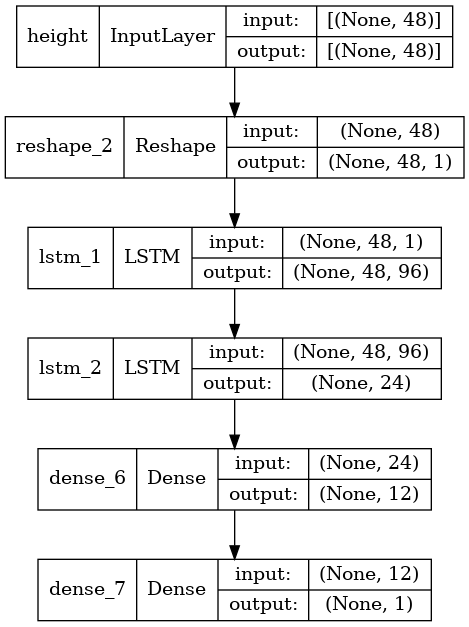

In [13]:
model_rnn_deep = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape = [N_INPUTS], name = TIMESERIES_COL),
    tf.keras.layers.Reshape(target_shape = [N_INPUTS, 1]),

    # why should I have a longer state than my input?
    # return_sequences == True so the internal state is fed in the next layer
    tf.keras.layers.LSTM(units = N_INPUTS * 2, return_sequences = True),

    tf.keras.layers.LSTM(units = N_INPUTS // 2),

    tf.keras.layers.Dense(units = (N_INPUTS // 2) // 2, activation = tf.nn.relu),
    tf.keras.layers.Dense(units = 1, activation = None)
])

model_rnn_deep.compile(optimizer='adam', loss = "mse", metrics = ["mse"])

tf.keras.utils.plot_model(model_rnn_deep, show_shapes=True)

Epoch 1/100
32/32 [==============================] - 4s 47ms/step - loss: 0.4377 - mse: 0.4377 - val_loss: 0.2189 - val_mse: 0.2189
Epoch 2/100
32/32 [==============================] - 1s 23ms/step - loss: 0.1649 - mse: 0.1649 - val_loss: 0.0870 - val_mse: 0.0870
Epoch 3/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0954 - mse: 0.0954 - val_loss: 0.0650 - val_mse: 0.0650
Epoch 4/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0582 - mse: 0.0582 - val_loss: 0.0496 - val_mse: 0.0496
Epoch 5/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0470 - mse: 0.0470 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 6/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0271 - val_mse: 0.0271
Epoch 7/100
32/32 [==============================] - 1s 20ms/step - loss: 0.0291 - mse: 0.0291 - val_loss: 0.0230 - val_mse: 0.0230
Epoch 8/100
32/32 [==============================] - 1s 20ms/step - loss: 0.

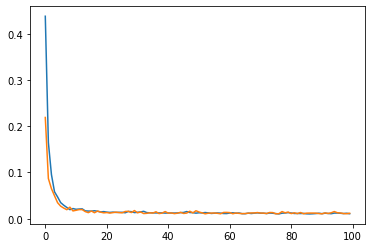

In [14]:
history = model_rnn_deep.fit(X_np, y, epochs=100, validation_data=(Xv, yv))
model_rnn_deep.evaluate(Xv, yv)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])